In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle, randint, sample

In [2]:
class GeneticAlgorithm:

    def __init__(self, n, m):
        self.n = n  # 遺伝子長
        self.m = m  # 個体数

    # 遺伝子の作成
    def generate_gene(self, x, y):
        gene = []
        for i in range(len(x)):
            gene.append((x.values[i], y.values[i]))
        return gene

    # 評価関数の作成
    def reputate(self, cities_arrs):
        f = []
        for i in range(self.m):
            x = []
            y = []
            d = []
            for j in range(self.n):
                x.append(cities_arrs[i][j][0])
                y.append(cities_arrs[i][j][1])
            for k in range(self.n-1):
                d.append(np.sqrt((x[k] - x[k+1]) ** 2 + (y[k] - y[k+1]) ** 2))
            f.append(np.array(d).sum())
        return f
        
    # 子の作成
    def generate_child(self, cities_arr0, cities_arr1):
        generated_gene = cities_arr0.copy()
        parent1 = cities_arr0.copy()
        parent2 = cities_arr1.copy()
        list1 = []
        list2 = list(range(0, self.n))
        change_n = randint(2,5)
        i = 0
        while True:
            a = randint(0, self.n-1)
            if not any(np.in1d(list1, a)):
                list1.append(a)
                list2.remove(list1[-1])
                i += 1
            if i == change_n:
                break

        for j in list1:
            parent2.remove(parent1[j])
        for (j, k) in zip(list2, range(0, len(parent2))):
            generated_gene[j] = parent2[k]
        return generated_gene

    # 変異種の作成（どこか2つの順番を入れ替える）
    def mutation(self, cities_arr):
        num1, num2 = randint(0, self.n-1), randint(0, self.n-1)
        tmp = cities_arr[num1]
        cities_arr[num1] = cities_arr[num2]
        cities_arr[num2] = tmp
        return cities_arr

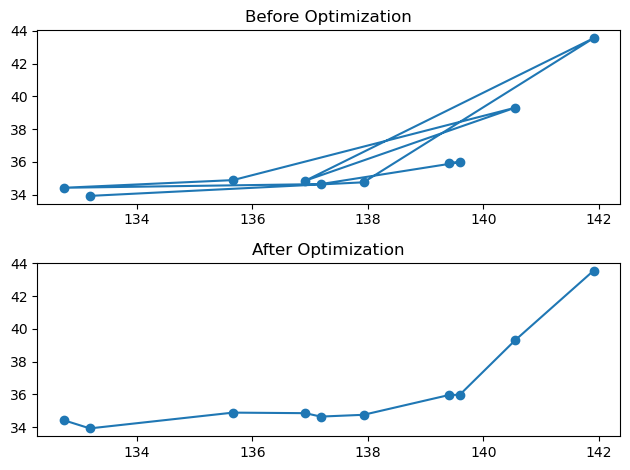

In [3]:
n = 10   # 都市数
m = 20   # 個体数
loop = 3000   # ループ回数
generation = 1   # 世代
reputation_hist = []   # 評価値の保存

# データの読み込み
japan = pd.read_csv('jp.csv')
cities = japan.sample(n)
cities = cities[['city', 'lat', 'lng']]
cities.head()

# 初期経路（最適化前）のプロット
x = cities['lng']
y = cities['lat']
plt.subplot(2, 1, 1).set_title('Before Optimization')
plt.scatter(x, y)
plt.plot(x, y)

GA = GeneticAlgorithm(n, m)

# 経路
gene_0 = GA.generate_gene(x, y)

# ランダムな経路m通りの遺伝子を生成
genes = []
for _ in range(m):
    gene_0 = sample(gene_0, n)
    genes.append(gene_0)

for _ in range(0, loop):
    
    # 評価（m通りの経路の各経路長を計算）
    reputation = GA.reputate(genes)

    # データ準備（m通りの経路とその経路長を紐付け）
    gene_dict = {}
    for i in range(m):
        gene_dict[i] = [genes[i], reputation[i]]

    df = pd.DataFrame(data=gene_dict, index=['gene', 'reputation'])
    df = df.T
    df = df.sort_values('reputation')
    df.reset_index(drop=True, inplace=True)
    
    # 評価値のリスト
    reputation_hist.append(df['reputation'][0])
    
    # 世代数のカウント
    # print(f'{generation}世代')
    # print(f'経路長：{reputation_hist[-1]}')
    # generation += 1

    # 評価値上位2つを選択する。ただし同じ配列のものは選ばない。
    genes = []
    genes.append(df['gene'][0])
    for i in range(len(df['gene'])):
        genes.append(df['gene'][i])
        if genes[0] == df['gene'][i]:
              genes.remove(genes[-1])
        else:
            break

    # 子をm-4個作成する。
    for _ in range(m-4):
        genes.append(GA.generate_child(genes[randint(0,1)], genes[abs(randint(0,1)-1)]))
        
    # 変異種を2つ作成する。
    genes.append(GA.mutation(genes[0]))
    genes.append(GA.mutation(genes[0]))

best_gene = df['gene'][0]
best_x = []
best_y = []
for i in range(0, len(best_gene)):
    best_x.append(best_gene[i][0])
    best_y.append(best_gene[i][1])
# 最適化後の経路のプロット
plt.subplot(2, 1, 2).set_title('After Optimization')
plt.scatter(best_x, best_y)
plt.plot(best_x, best_y)
plt.tight_layout()
plt.show()